# Purchase History and Market Basket Analysis

Company XYZ is an online grocery store. In the current version of the website, they have manually grouped the items into a few categories based on their experience.

However, they now have a lot of data about user purchase history. Therefore, they would like to put the data into use!

This is what they asked you to do:

- The company founder wants to meet with some of the best customers to go through a focus group with them. You are asked to send the ID of the following customers to the founder:
 - the customer who bought the most items overall in her lifetime
 - for each item, the customer who bought that product the most
- Cluster items based on user co-purchase history. That is, create clusters of products that have the highest probability of being bought together. The goal of this is to replace the old/manually created categories with these new ones. Each item can belong to just one cluster.

# Index
1. [Initial Exploration](#explore)
2. [Top Customers](#topcustomers)
    1. [Overall](#overall)
    2. [Each Item](#eachitem)
3. [Clustering Products](#cluster)
    1. [K-Means](#kmeans)
    2. [Correlation](#correlation)
4. [Market Basket Analysis](#mba)
5. [Conclusions](#conclusions)

<a name='explore'></a>
# Initial Exploration

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [15]:
item_ids = pd.read_csv('https://raw.githubusercontent.com/bundickm/DataMasked---Private/main/CSVs/item_to_id.csv?token=ALJ4RG4IP3QTKM476RRVIUDADM2H4')
print(item_ids.shape)
item_ids.head()

(48, 2)


,Item_name,Item_id
0,coffee,43
1,tea,23
2,juice,38
3,soda,9
4,sandwich loaves,39


In [16]:
purchases = pd.read_csv('https://raw.githubusercontent.com/bundickm/DataMasked---Private/main/CSVs/purchase_history.csv?token=ALJ4RG42IZXKV6HHLXKJRQLADM2K4')
print(purchases.shape)
purchases.head()

(39474, 2)


,user_id,id
0,222087,"27,26"
1,1343649,"6,47,17"
2,404134,"18,12,23,22,27,43,38,20,35,1"
3,1110200,"9,23,2,20,26,47,37"
4,224107,"31,18,5,13,1,21,48,16,26,2,44,32,20,37,42,35,4..."


We need to split the item ID's into individual columns, then rename them to their item names, and combine the purchase history of individual users.

In [17]:
onehots = purchases['id'].str.split('\s*,\s*',
                            expand=True).stack().str.get_dummies().sum(level=0)
purchases = purchases.drop('id', axis='columns').merge(onehots, 
                                            left_index=True, right_index=True)

In [18]:
item_map = {str(key): value for key, value in 
            item_ids.set_index('Item_id').to_dict()['Item_name'].items()}
purchases = purchases.rename(item_map, axis='columns').set_index('user_id')
purchases = purchases.groupby('user_id').sum()

In [19]:
purchases.head()

,sugar,carrots,cereals,shampoo,bagels,eggs,aluminum foil,milk,beef,laundry detergent,shaving cream,lettuce,grapefruit,cheeses,frozen vegetables,tea,paper towels,cherries,spaghetti sauce,dishwashing,canned vegetables,hand soap,pet items,flour,pasta,apples,toilet paper,tortillas,soap,ice cream,dinner rolls,juice,sandwich loaves,baby items,berries,ketchup,cucumbers,coffee,broccoli,cauliflower,bananas,pork,yogurt,waffles,poultry,sandwich bags,butter,soda
user_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
47,0,0,0,0,1,0,1,1,0,0,0,1,0,0,0,1,1,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,1,0,0,0,0,0,0,0
68,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0
113,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,1,0,1,1,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1
123,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
223,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0


<a name='topcustomers'></a>
# Top Customers

<a name='overall'></a>
To get the customer who purchased the most items we simply need to sum all of the counts and sort in descending order.

We see that customer 269335 has purchased the most items with 72.

In [20]:
purchases.T.sum().sort_values(ascending=False).reset_index().rename({0:'count'},
                                                             axis='columns')[:1]

,user_id,count
0,269335,72


<a name='eachitem'></a>
Gettting the customer who purchased each item the most is a simple call to `idxmax` which gives us the first occurence of the maximum value over the defined axis.

In [21]:
pd.DataFrame(purchases.idxmax().T).rename({0:'customer'}, axis='columns')

,customer
sugar,31625
carrots,618914
cereals,367872
shampoo,557904
bagels,653800
eggs,172120
aluminum foil,143741
milk,73071
beef,366155
laundry detergent,917199


<a name='clustering'></a>
# Clustering Products

<a name='kmeans'></a>
K-Means clustering is going to be where we start, allowing us to easily find groupings of products.

We'll start by determining how many groupings is optimal by looking at an elbow and silhoutte plot.

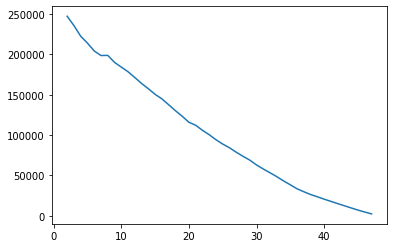

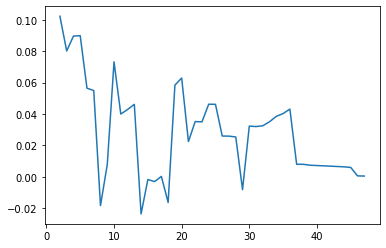

In [22]:
clusters = range(2, 48)
elbow = []
silhouette = []

for n in clusters:
    kmeans = KMeans(n_clusters=n, random_state=13, n_jobs=-1)
    kmeans = kmeans.fit(purchases.T)
    label = kmeans.predict(purchases.T)
    
    elbow.append(kmeans.inertia_)
    silhouette.append(silhouette_score(purchases.T, label))

plt.plot(clusters, elbow)
plt.show()
plt.plot(clusters, silhouette)
plt.show()

There doesn't seem to be a clear point on either graph for optimal number of clusters. I tested multiple points and found 11 clusters to be the best based on the what items are in each group.

The resulting groups are not great. Some, like `Group 0`, are coherent but we also see plenty of groups that are a single item and one catch-all group where most of the items reside.

In [10]:
GROUPS = 11

kmeans = KMeans(n_clusters=GROUPS, random_state=13, n_jobs=-1)
kmeans = kmeans.fit(purchases.T)
label = kmeans.predict(purchases.T)

df = pd.DataFrame({'Item Name': purchases.columns, 'Group': label})
for i in range(GROUPS):
    print('\nGroup:', i)
    print(list(df[df['Group'] == i]['Item Name']))


Group: 0
['shampoo', 'shaving cream', 'hand soap', 'soap']

Group: 1
['lettuce']

Group: 2
['bananas']

Group: 3
['berries']

Group: 4
['sugar', 'cereals', 'eggs', 'aluminum foil', 'milk', 'laundry detergent', 'cheeses', 'frozen vegetables', 'paper towels', 'spaghetti sauce', 'dishwashing\xa0', 'canned vegetables', 'pet items', 'flour', 'pasta', 'toilet paper', 'ice cream', 'baby items', 'ketchup', 'broccoli', 'cauliflower', 'yogurt', 'waffles', 'sandwich bags', 'butter']

Group: 5
['bagels', 'tortillas', 'dinner rolls', 'sandwich loaves']

Group: 6
['beef', 'pork', 'poultry']

Group: 7
['grapefruit', 'cherries']

Group: 8
['apples']

Group: 9
['tea', 'juice', 'coffee', 'soda']

Group: 10
['carrots', 'cucumbers']


<a name='correlation'></a>
The groups created from K-means clustering don't seem terribly helpful so we'll see if we can find another way to programmatically group them. The core of the method below is to group items by their correlation coeffecient. The higher the correlation the more likely the items are to show up together. The other portion of this method is to make sure each item is in only one group, something we can correct with the use of `set` and `frozenset`.

In [23]:
def create_groups(items, df):
    # Create groups based off item correlations ordered high to low
    groups = dict()
    cats = set()

    for col in items:
        groups[col] = set(df.corr()[col].sort_values(ascending=False)[0:5].index)

    for col in items:
        for col2 in items:
            if (groups[col] == groups[col2]) and (col != col2):
                cats.add(frozenset(groups[col]))
    
    return cats

In [24]:
def filter_groups(groups):
    # Cycle through the created groups and remove dupes, output the clean groups
    # and the miscellaneous items that are groupless
    unique_groups = set()
    items = []

    for group in groups:
        temp = set(group)
        for group2 in groups:
            if group != group2:
                temp.difference_update(set(group2))
        unique_groups.add(frozenset(temp))
        items += list(temp)

    return unique_groups, items

We'll perform two passes with the above functions. The first pass generates 12 ungrouped items. One of the main drawbacks of our k-means groups is a large catch-all group and a lot of single item groups so we want to find a better way to deal with those 12 items. The solution is to do another pass through the two functions. We still end up with some miscellaneous items but overall we end up with better groupings. At this point, you could do some manual corrections of some of the items/groups but overall the groups are more coherent than we had above.

In [26]:
unique_groups, items = filter_groups(create_groups(purchases.columns, purchases))
misc = list(set(purchases.columns).difference(set(items)))

misc_groups, items2 = filter_groups(create_groups(misc, purchases[misc]))
misc = list(set(purchases.columns).difference(set(items + items2)))

for group in misc_groups:
    unique_groups.add(group)
unique_groups.add(frozenset(misc))

unique_groups

12


{frozenset({'apples', 'bananas', 'berries', 'cherries', 'grapefruit'}),
 frozenset({'bagels', 'dinner rolls', 'sandwich loaves', 'tortillas'}),
 frozenset({'broccoli', 'carrots', 'cauliflower', 'cucumbers'}),
 frozenset({'beef',
            'cereals',
            'dishwashing\xa0',
            'laundry detergent',
            'lettuce',
            'pork',
            'sugar'}),
 frozenset({'coffee', 'juice', 'soda', 'tea'}),
 frozenset({'aluminum foil', 'paper towels', 'sandwich bags', 'toilet paper'}),
 frozenset({'poultry'}),
 frozenset({'flour', 'pasta', 'waffles'}),
 frozenset({'butter', 'cheeses', 'eggs', 'milk', 'yogurt'}),
 frozenset({'hand soap', 'shampoo', 'shaving cream', 'soap'}),
 frozenset({'baby items', 'pet items'}),
 frozenset({'canned vegetables', 'ketchup', 'spaghetti sauce'}),
 frozenset({'frozen vegetables', 'ice cream'})}